In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-l_b9faay
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-l_b9faay


# Car Detection


tensor([0, 2], device='cuda:0')
Boxes(tensor([[ 619.5560,  374.5608,  793.6017,  540.9788],
        [ 262.9050,  106.4870,  944.8198, 1019.8591]], device='cuda:0'))


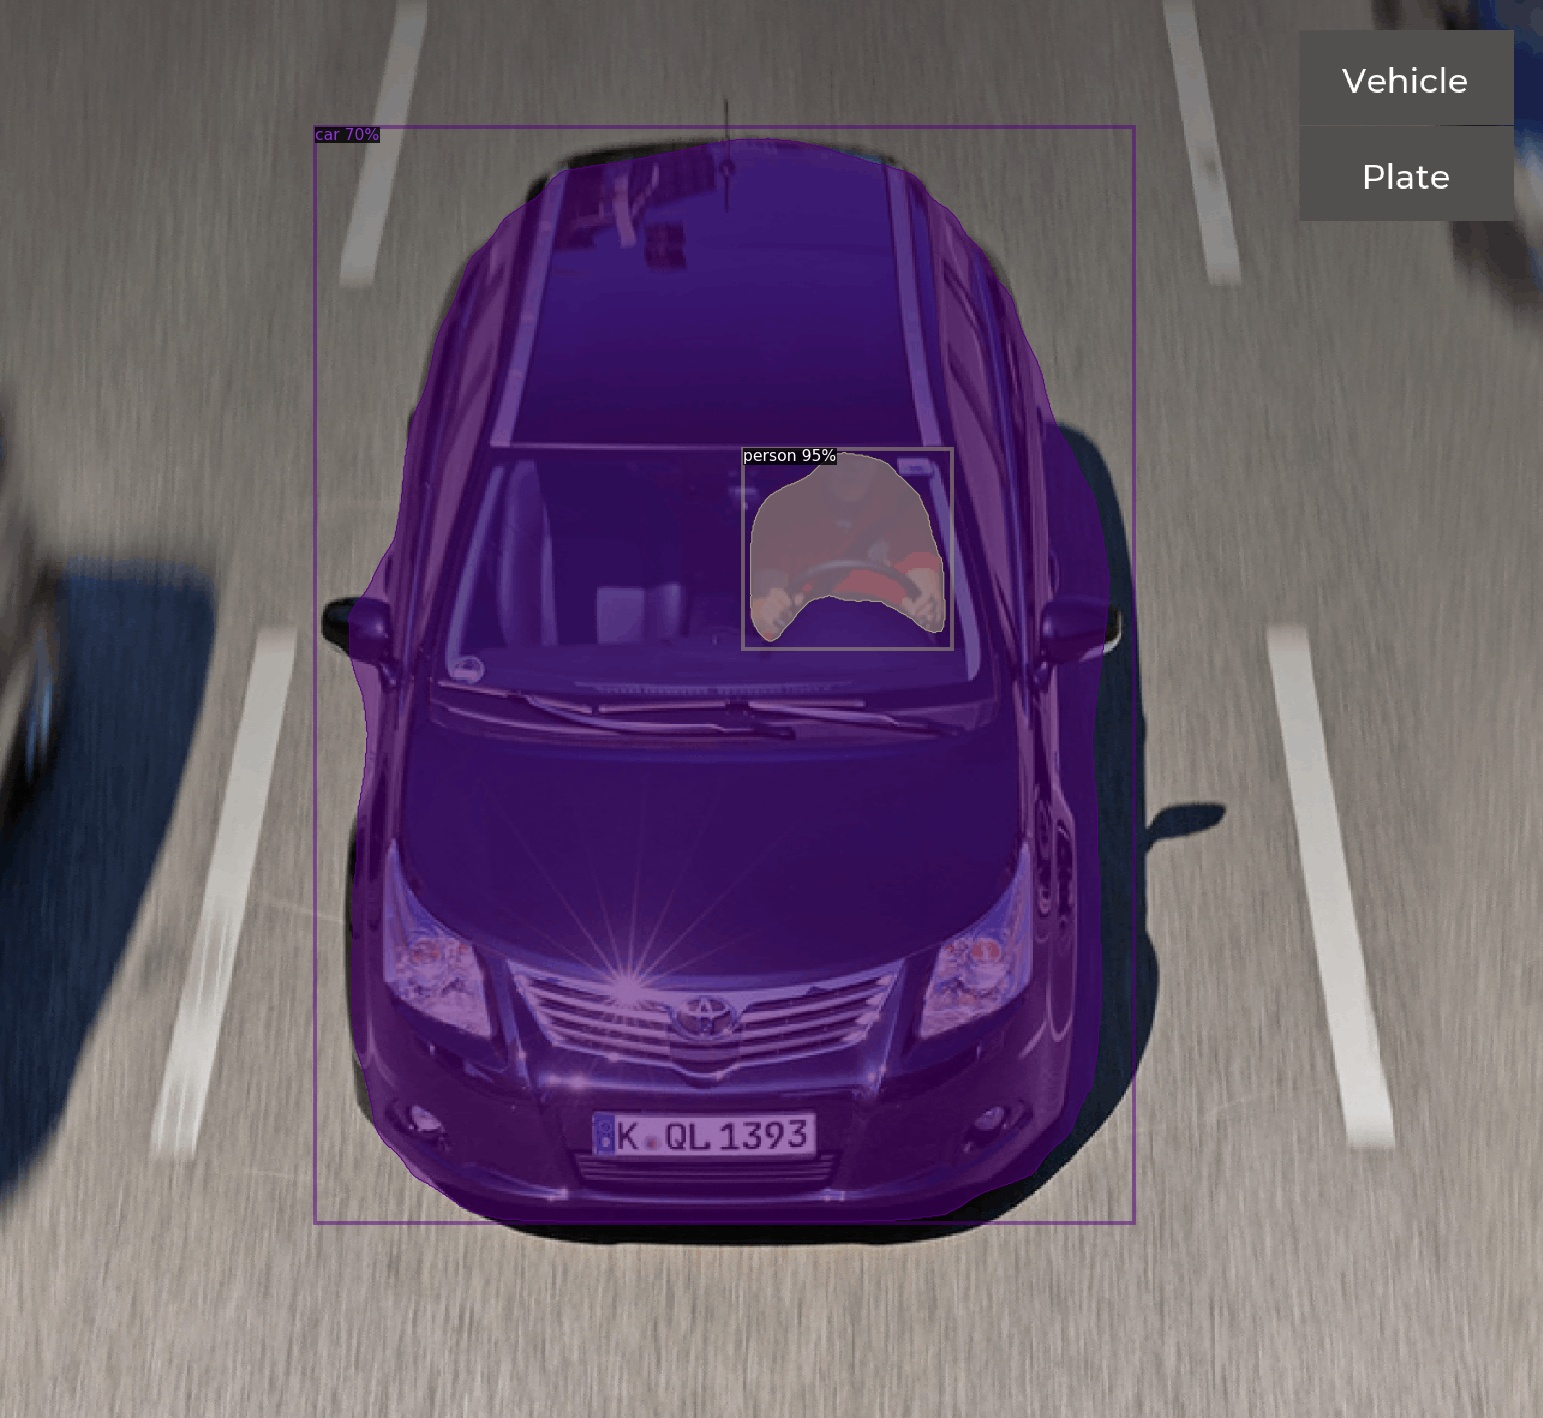

tensor([2], device='cuda:0')
Boxes(tensor([[ 67.2078,  85.0681, 522.9947, 301.6839]], device='cuda:0'))


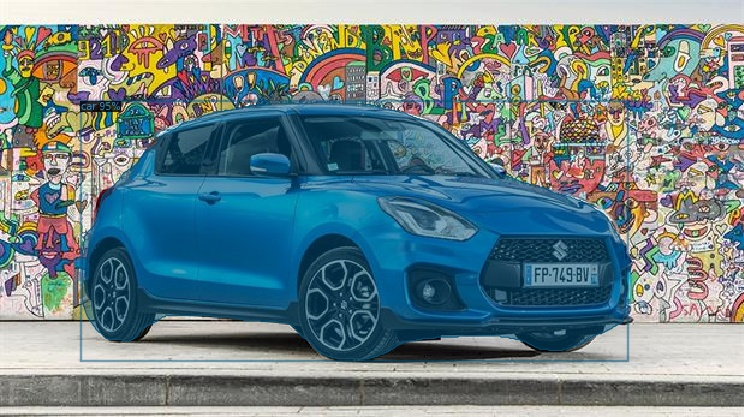

tensor([0, 2], device='cuda:0')
Boxes(tensor([[1054.0438,  277.2340, 1220.3083,  414.3742],
        [ 296.6602,  141.4447, 2198.7607, 1129.8046]], device='cuda:0'))


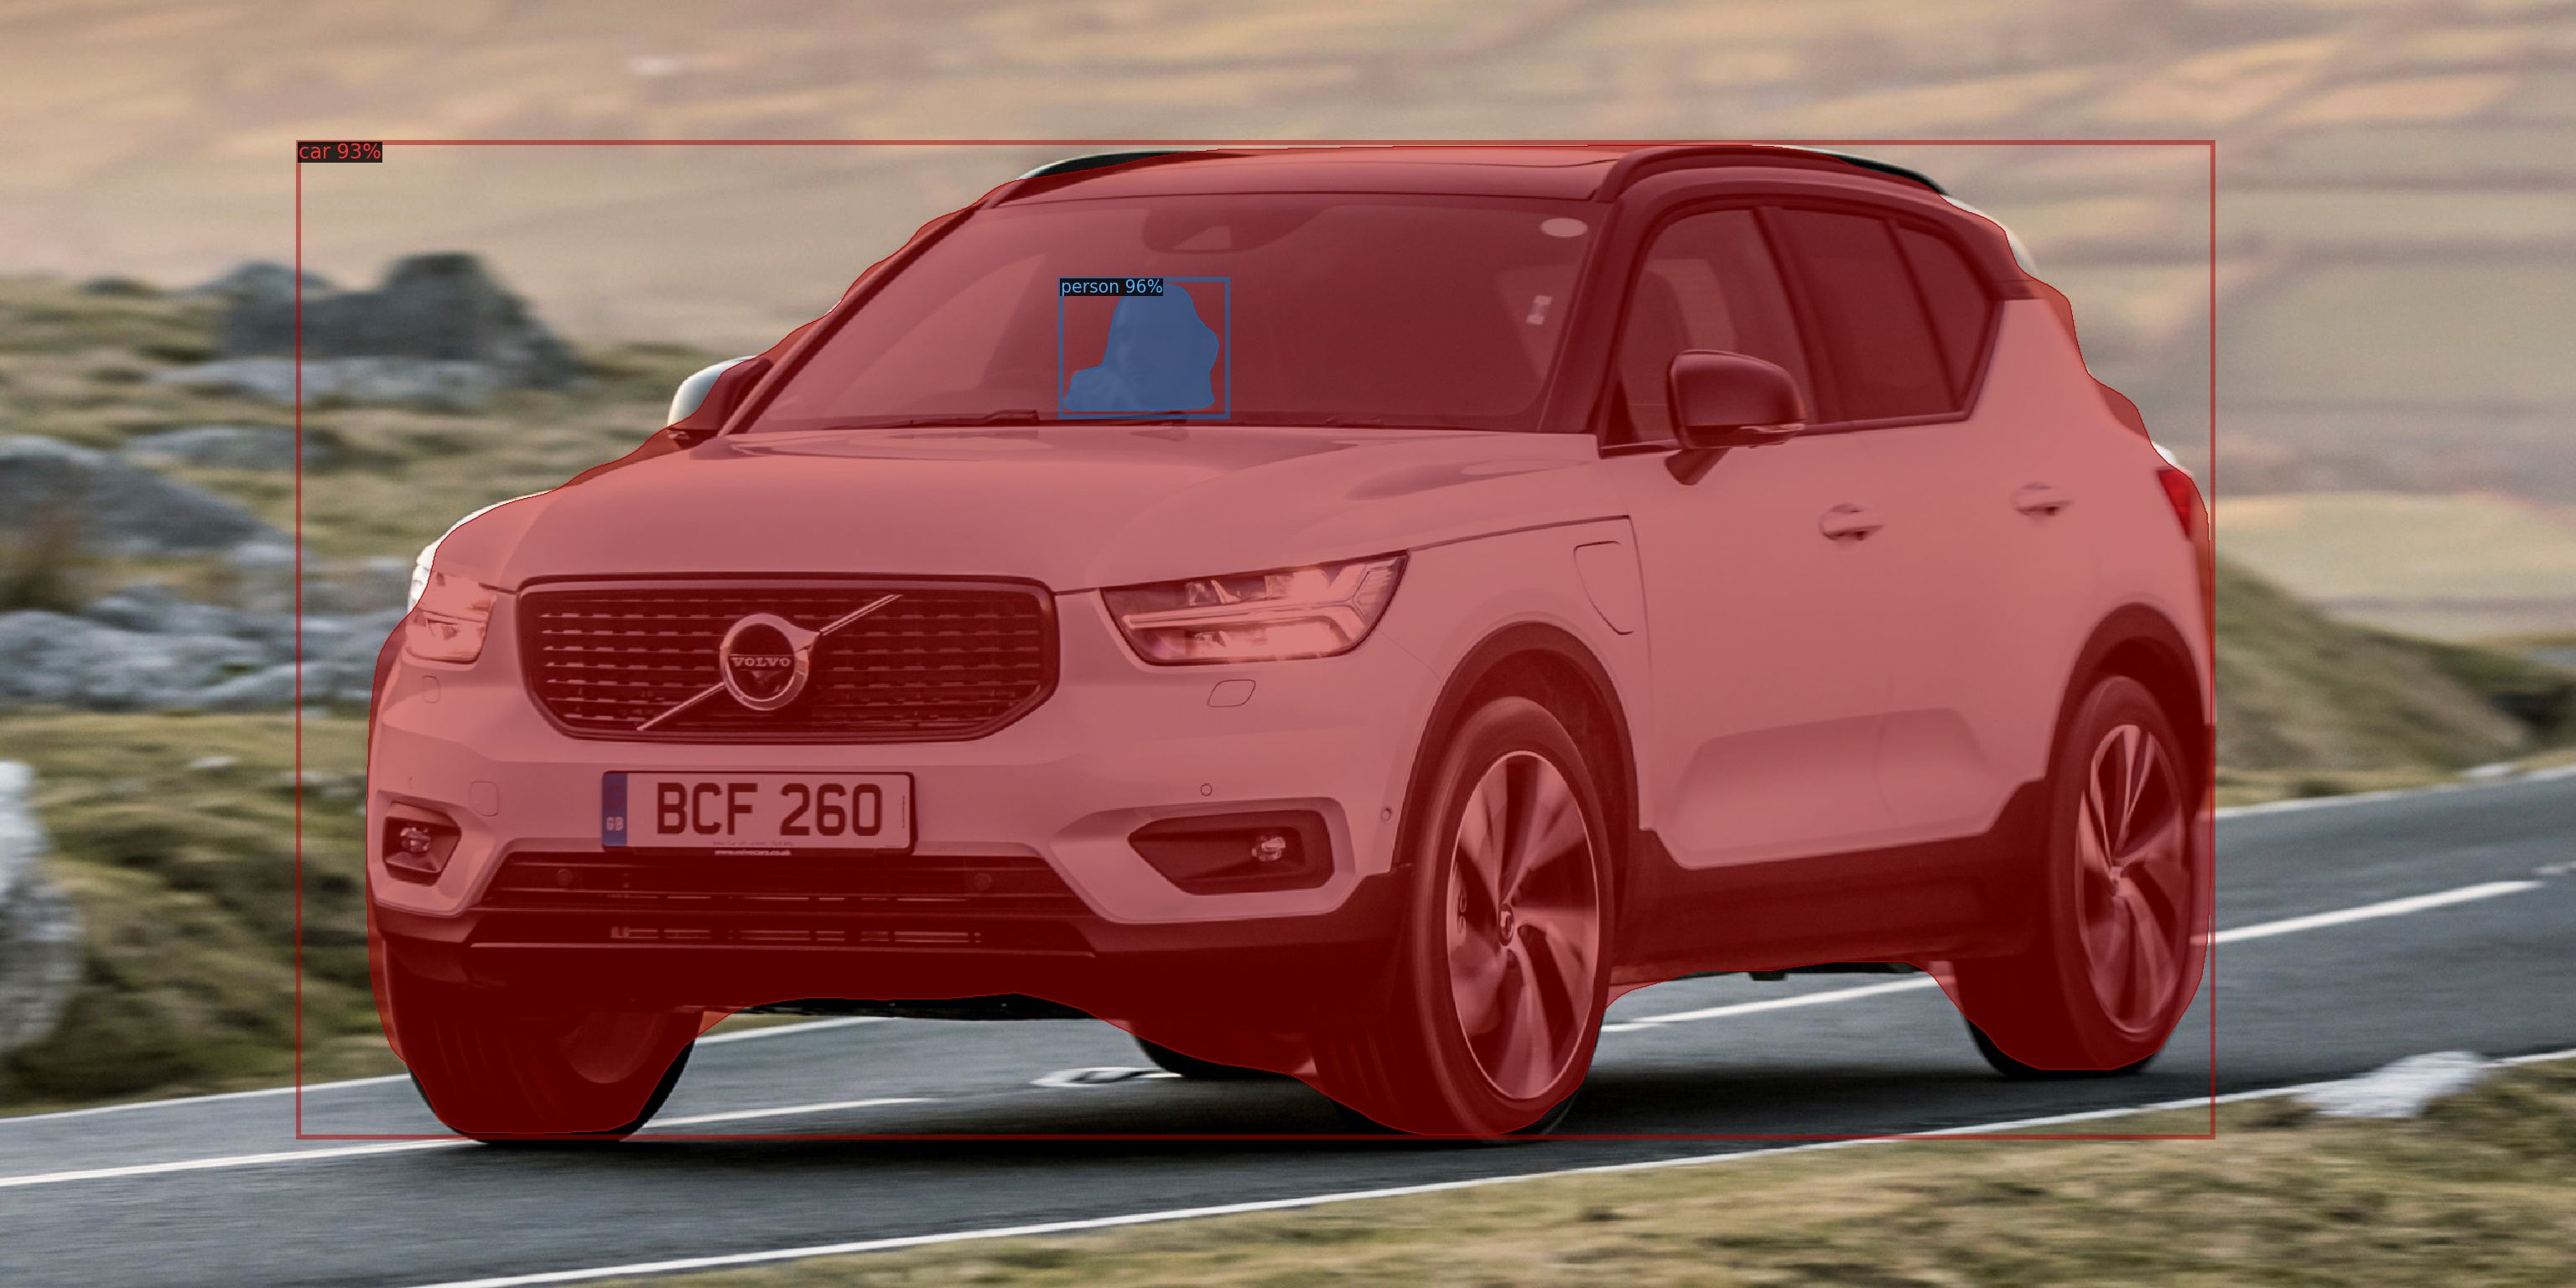

tensor([2], device='cuda:0')
Boxes(tensor([[202.8286,  40.3731, 352.4676, 158.1181]], device='cuda:0'))


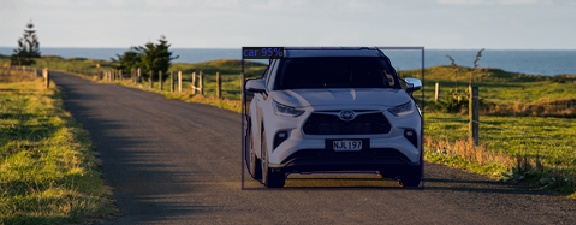

In [6]:
import detectron2
import cv2
import os
import platform
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
if any(platform.win32_ver()):
  base_dir='./car'
  def cv2_imshow(img):       
        import IPython
        _,ret = cv2.imencode('.jpg', img) 
        i = IPython.display.Image(data=ret)
        IPython.display.display(i)
else:      
  from google.colab.patches import cv2_imshow
  base_dir='/content/drive/MyDrive/data/car'

def detect_img(predictor,im):
  outputs = predictor(im)
  print(outputs["instances"].pred_classes)
  print(outputs["instances"].pred_boxes)
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow( out.get_image()[:, :, ::-1])

cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
predictor = DefaultPredictor(cfg)


for test_file in os.listdir(base_dir):       
        if test_file.endswith(".gif"):
          cap = cv2.VideoCapture(os.path.join(base_dir,test_file))
          ret, image = cap.read()
          cap.release()
          if cap:
            im=image
        else:
          im = cv2.imread(os.path.join(base_dir,test_file))
        if im is not None:
          detect_img(predictor,im)
        

tensor([ 0,  0,  0, 20,  0], device='cuda:0')
Boxes(tensor([[268.0551, 329.3857, 316.4725, 409.0632],
        [323.9795, 327.2056, 369.7097, 412.0058],
        [316.3805, 327.9458, 346.2695, 406.9662],
        [291.9850, 301.1780, 411.0214, 409.7128],
        [296.9951, 327.3564, 341.6170, 415.6180]], device='cuda:0'))


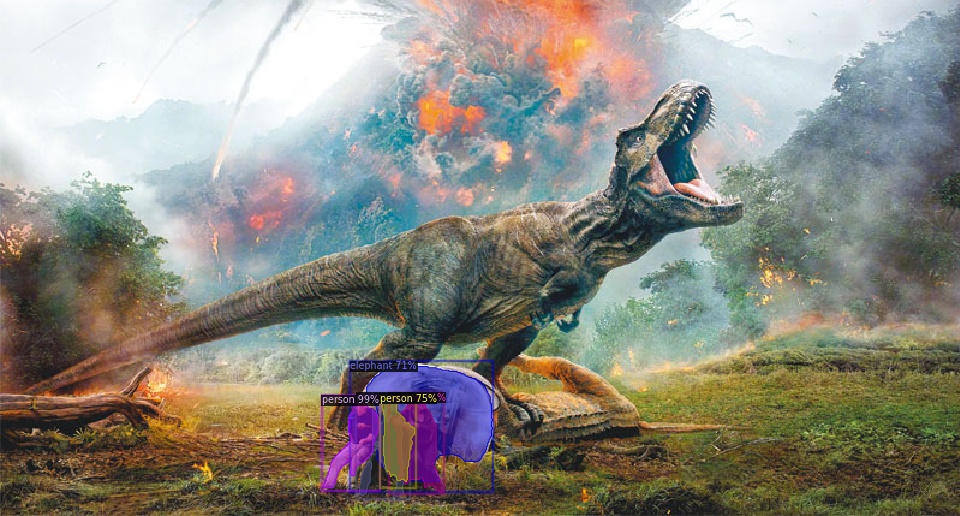

In [7]:
if any(platform.win32_ver()):
    trax_file="./test/wd06209-5349-0729-001.jpg"
else:
    trax_file="/content/drive/MyDrive/data/trax/test/wd06209-5349-0729-001.jpg"
detect_img(predictor,cv2.imread(trax_file))

# Transfer Learning

In [1]:
import detectron2
import platform
# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer



In [2]:
if any(platform.win32_ver()):
    base_path='./'
    def cv2_imshow(img):       
        import IPython
        _,ret = cv2.imencode('.jpg', img) 
        i = IPython.display.Image(data=ret)
        IPython.display.display(i)
else:
    base_path="/content/drive/MyDrive/data/trax/"
    from google.colab.patches import cv2_imshow


  

In [10]:
!pip install labelme2coco
# import package
import labelme2coco

# set directory that contains labelme annotations and image files
labelme_folder = os.path.join(base_path,"mask")

# set path for coco json to be saved
save_json_path =  os.path.join(base_path,"mask","test_coco.json")

os.remove(save_json_path) if os.path.exists(save_json_path) else None
# convert labelme annotations to coco
labelme2coco.convert(labelme_folder, save_json_path)


In [3]:
register_coco_instances("trax", {}, os.path.join(base_path,"mask/test_coco.json"), base_path)

In [6]:
cfg = get_cfg()
model_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(model_name))
cfg.DATASETS.TRAIN = ("trax",)
cfg.DATASETS.TEST = ()
cfg.OUTPUT_DIR=os.path.join(base_path,"output")



In [7]:
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    model_name
)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH =4
cfg.SOLVER.BASE_LR = 0.00055  # pick a good LR
cfg.SOLVER.MAX_ITER = 100
cfg.SOLVER.STEPS = []  # do not decay learning rate

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/19 15:35:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[09/19 15:35:59 d2.data.datasets.coco]: Loaded 30 images in COCO format from ./mask/test_coco.json
[09/19 15:35:59 d2.data.build]: Removed 0 images with no usable annotations. 30 images left.
[09/19 15:35:59 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    Trex    | 35           |
|            |              |
[09/19 15:35:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/19 15:35:59 d2.data.build]: Using training sampler TrainingSampler
[09/19 15:35:59 d2.data.common]: Serializing 30 elements to byte tensors and concatenating them all ...
[09/19 15:35:59 d2.data.common]: Serialized dataset takes 0.07 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[09/19 15:36:02 d2.engine.train_loop]: Starting training from iteration 0


F:\python\envs\py8\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
F:\python\envs\py8\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


ERROR [09/19 15:36:13 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "F:\python\envs\py8\lib\site-packages\detectron2\engine\train_loop.py", line 149, in train
    self.run_step()
  File "F:\python\envs\py8\lib\site-packages\detectron2\engine\defaults.py", line 493, in run_step
    self._trainer.run_step()
  File "F:\python\envs\py8\lib\site-packages\detectron2\engine\train_loop.py", line 285, in run_step
    losses.backward()
  File "F:\python\envs\py8\lib\site-packages\torch\_tensor.py", line 255, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "F:\python\envs\py8\lib\site-packages\torch\autograd\__init__.py", line 147, in backward
    Variable._execution_engine.run_backward(
RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 8.00 GiB total capacity; 3.82 GiB already allocated; 1.92 GiB free; 3.95 GiB reserved in total by PyTorch)
[09/19 15:36:13 d2.engine.hooks]:

RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 8.00 GiB total capacity; 3.82 GiB already allocated; 1.92 GiB free; 3.95 GiB reserved in total by PyTorch)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[1.0569e+01, 2.0265e+02, 4.7017e+02, 4.0409e+02],
        [2.7056e+02, 3.7988e+02, 3.3341e+02, 4.0460e+02],
        [4.9265e+02, 2.4496e+02, 5.3908e+02, 2.7464e+02],
        [9.7261e+00, 3.7044e+02, 2.2274e+02, 4.0451e+02],
        [2.6044e+02, 3.3873e+02, 3.4358e+02, 3.9368e+02],
        [1.0839e+01, 1.7528e+02, 2.8193e+02, 3.0643e+02],
        [2.2472e+02, 3.2911e+02, 5.2551e+02, 3.9282e+02],
        [3.3783e-01, 2.4085e+02, 3.0474e+02, 3.5384e+02],
        [4.2566e+02, 1.4099e+01, 5.2055e+02, 1.0377e+02],
        [3.4467e+02, 3.0722e+02, 5.1489e+02, 3.4000e+02],
        [2.5029e+02, 3.1132e+02, 5.6993e+02, 3.7641e+02],
        [2.3296e+02, 3.2976e+02, 2.4360e+02, 3.3714e+02],
        [2.1945e+02, 3.1279e+02, 2.2492e+02, 3.1922e+02],
        [

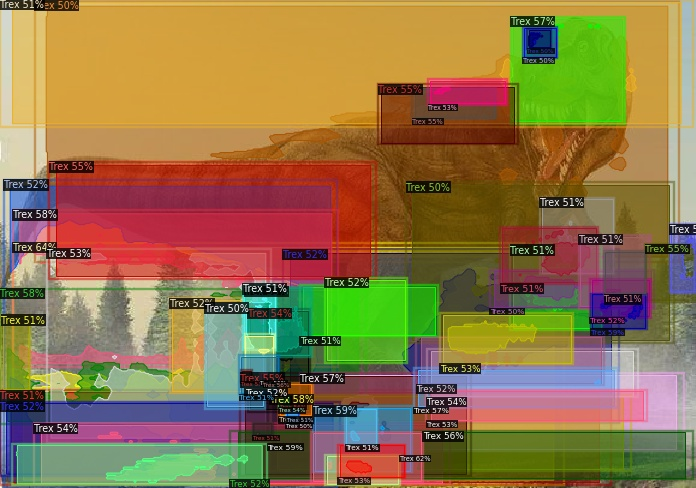

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0')
Boxes(tensor([[0.0000e+00, 1.5258e+02, 4.5679e+01, 1.7086e+02],
        [2.4359e+02, 1.3538e+02, 2.6653e+02, 1.4684e+02],
        [9.7286e+01, 1.3839e+02, 2.8348e+02, 1.7684e+02],
        [2.4848e+02, 1.3376e+02, 2.6395e+02, 1.5141e+02],
        [1.2723e+02, 1.4556e+02, 1.7982e+02, 1.6485e+02],
        [2.2019e+02, 5.4799e+01, 2.7098e+02, 7.0505e+01],
        [1.9010e+02, 1.0007e+02, 2.0184e+02, 1.1253e+02],
        [2.0765e+02, 1.5503e+02, 2.5361e+02, 1.6053e+02],
        [9.3845e+01, 1.4419e+02, 2.2345e+02, 1.7120e+02],
        [2.4410e+02, 1.4019e+02, 2.4897e+02, 1.5233e+02],
        [1.9919e+02, 1.5453e+02, 2.7691e+02, 1.6616e+02],
        [1.8940e+02, 1.1700e+02, 2.1495e+02, 1.2975e+02],
        [2.5346e+00, 1.346

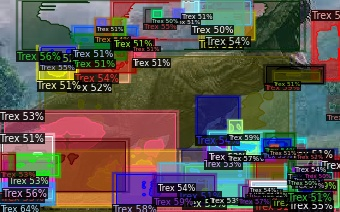

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
Boxes(tensor([[9.0808e-01, 5.2197e+02, 4.6650e+02, 6.6819e+02],
        [2.2088e-01, 3.8313e+02, 5.8363e+02, 6.7464e+02],
        [2.3454e+02, 5.8378e+02, 4.0309e+02, 6.7455e+02],
        [9.6209e+01, 1.9358e+02, 8.9702e+02, 6.7434e+02],
        [6.5815e+00, 5.4245e+02, 1.0797e+02, 6.7478e+02],
        [1.0591e+03, 1.7812e-01, 1.1179e+03, 5.5758e+01],
        [1.9736e+02, 1.1685e+02, 2.4663e+02, 1.3600e+02],
        [9.5145e+01, 7.1474e+01, 3.2379e+02, 1.3450e+02],
        [1.8822e+02, 1.1373e+02, 2.9782e+02, 1.3980e+02],
        [1.0488e+03, 4.7564e+02, 1.0638e+03, 4.8845e+02],
        [2.1247e+02, 5.1584e+02, 6.0206e+02, 6.7447e+02],
        [4.0484e+01, 3.1115e+02, 4.7140e+02, 5.0301e+02],
        [1.9504e+01, 3.6641e+02, 

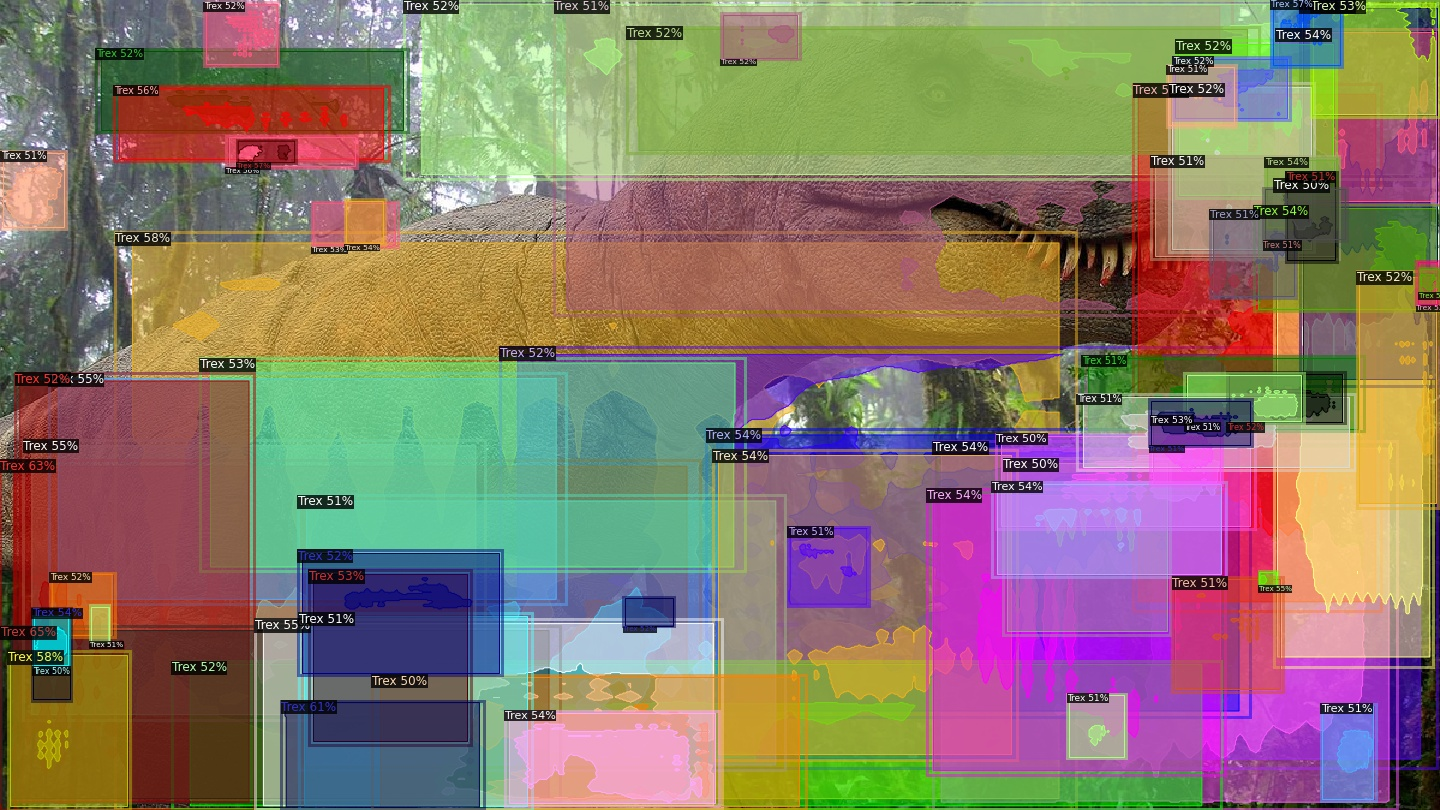

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[9.1765e+02, 6.5268e+02, 1.1647e+03, 6.7396e+02],
        [1.0104e+03, 8.4669e+01, 1.1008e+03, 1.9510e+02],
        [1.0074e+03, 6.4969e+02, 1.1173e+03, 6.6907e+02],
        [1.0130e+03, 9.4508e+01, 1.0930e+03, 1.4882e+02],
        [0.0000e+00, 3.9761e+02, 7.4868e+02, 6.7353e+02],
        [1.0327e+03, 6.5765e+01, 1.1798e+03, 2.2061e+02],
        [1.0758e+03, 9.7249e+01, 1.1953e+03, 2.4078e+02],
        [1.0750e+03, 5.2847e+01, 1.1977e+03, 1.7776e+02],
        [1.1432e+03, 3.8249e+02, 1.1938e+03, 4.9474e+02],
        [1.0139e+03, 6.5598e+02, 1.0785e+03, 6.7193e+02],
        [7.0077e+02, 4.9121e+02, 1.1883e+03, 6.5170e+02],
        [4.1740e+02, 5.5393e+02, 1.1969e+03, 

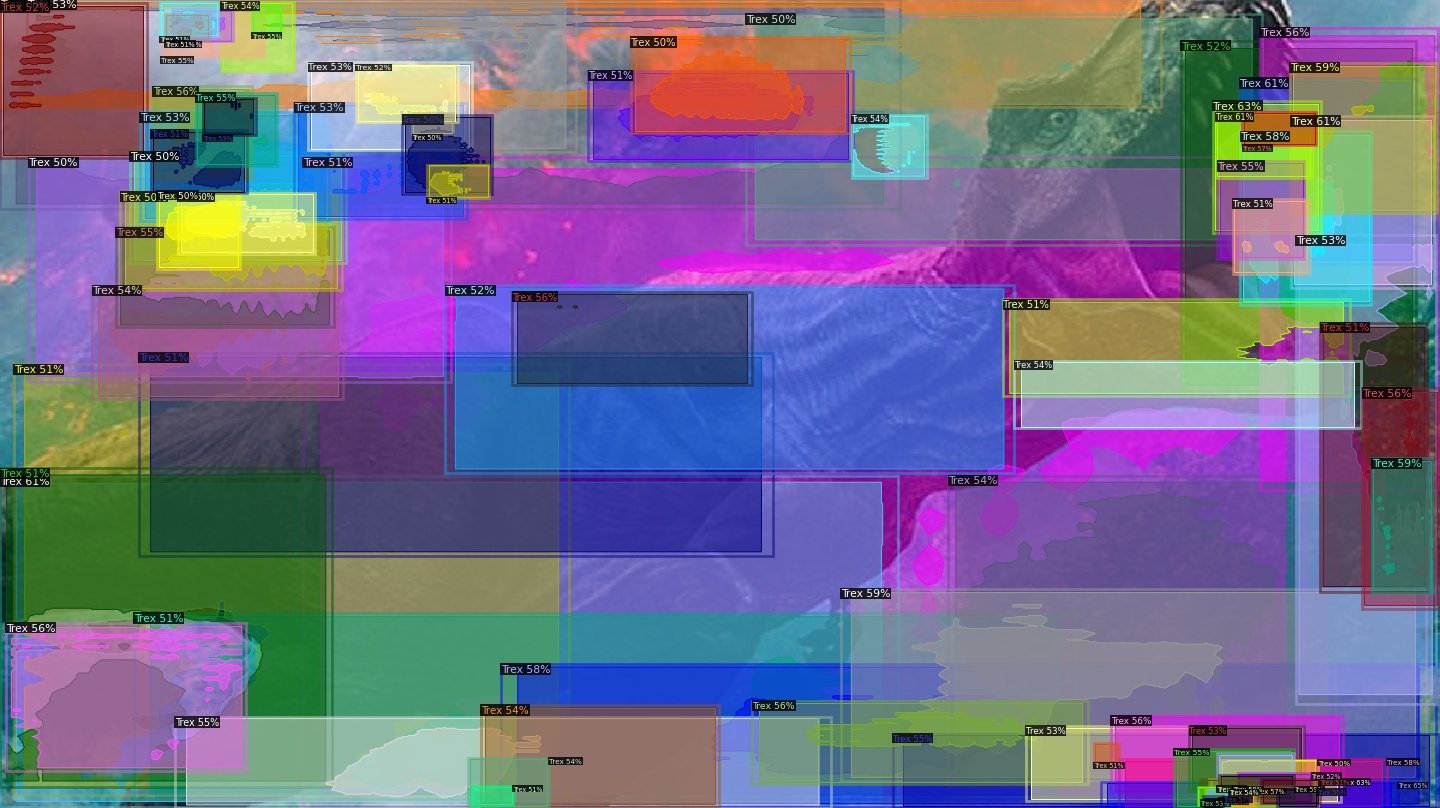

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[  0.0000, 138.5984, 116.3194, 188.5629],
        [ 25.3836, 111.9291, 208.4851, 196.7213],
        [ 10.4121,  85.8115, 110.2246, 107.9667],
        [175.3066, 156.5548, 203.4941, 184.8939],
        [ 88.0521, 185.0307, 199.0592, 195.9066],
        [155.0581, 122.8848, 255.5406, 196.2392],
        [199.1468, 180.8130, 203.1723, 184.8728],
        [  1.1981,   0.0000, 234.0128,  93.2180],
        [  6.2069, 153.5275, 161.3238, 192.7506],
        [  6.1270,  84.9027,  63.1133,  95.4341],
        [  5.4334,  78.2849, 103.0759,  98.7405],
        [107.0285, 156.6520, 144.5655, 194.1346],
        [ 90.4281, 177.5339, 184.7589, 195.0701],
        [108.7122, 185.5219, 142.5916, 195.8923],
        [181.8350, 173.3921, 200.0136, 187.7121],
       

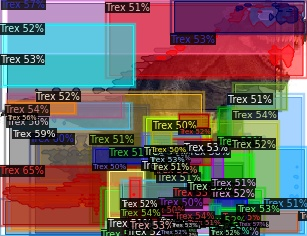

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[8.7212e+01, 1.1846e+02, 1.3964e+02, 1.5237e+02],
        [6.9418e+01, 1.2838e+02, 9.3850e+01, 1.4142e+02],
        [6.6556e+01, 1.9480e+02, 1.7376e+02, 2.1053e+02],
        [5.0049e+01, 1.7346e+02, 1.9428e+02, 2.1087e+02],
        [5.9885e+01, 2.0176e+02, 2.0797e+02, 2.1230e+02],
        [1.7602e+01, 1.5024e+02, 2.1822e+02, 2.1874e+02],
        [5.7806e+01, 1.9069e+02, 1.4444e+02, 2.0777e+02],
        [5.8065e+00, 3.0457e+00, 7.8370e+01, 3.3779e+01],
        [4.9318e+01, 1.6129e+02, 1.5726e+02, 2.0412e+02],
        [2.1399e+01, 1.0218e+02, 1.3423e+02, 1.5305e+02],
        [2.6752e+01, 1.1896e+02, 7.7728e+01, 1.4282e+02],
        [1.9058e+01, 6.6405e+01, 3.3492e+01, 7.5909e+01],
        [1.1328e+02, 1.6423e+02, 1.3279e+02, 1.9047e+02],
        [7.1974e+01, 1.0131e+0

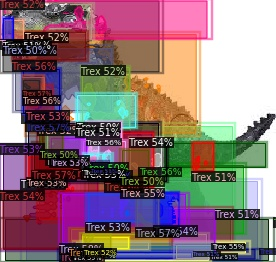

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], device='cuda:0')
Boxes(tensor([[199.7677,  80.9115, 244.6353, 101.4203],
        [ 82.1694, 167.9831,  96.6508, 173.9037],
        [106.8993, 144.2324, 148.7349, 160.8753],
        [ 76.9246, 160.2388,  98.5252, 170.4870],
        [ 81.9687, 166.2624,  95.2932, 170.6107],
        [105.8176,  81.1015, 144.1506, 154.4390],
        [123.2244, 157.3455, 137.5201, 161.4444],
        [ 79.6024, 169.2919, 166.3753, 181.5819],
        [121.5494, 155.2808, 148.7997, 161.5732],
        [115.6435, 147.7885, 141.2589, 157.5078],
        [188.5757,  73.0401, 235.7027, 102.5057],
        [213.2839,  51.6603, 225.1430,  71.2974],
        [ 90.7206, 160.1310, 149.1918, 179.6964],
        [ 72.6839, 138.6149,  80.1742, 147.8417],
        [ 20.4656, 

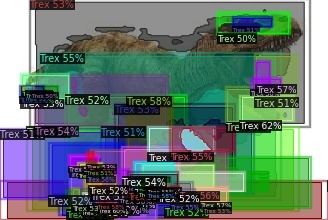

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[5.8261e+01, 5.5797e+01, 9.8224e+01, 7.9800e+01],
        [5.9698e+00, 1.5814e+02, 1.3152e+02, 1.9247e+02],
        [5.4089e+01, 4.2839e+01, 1.0018e+02, 7.4004e+01],
        [0.0000e+00, 3.4239e+01, 2.9952e+01, 6.9505e+01],
        [1.0925e+02, 5.4329e+01, 1.4571e+02, 7.5462e+01],
        [1.2612e+02, 4.0526e+01, 1.7458e+02, 6.8781e+01],
        [5.9876e+01, 3.6191e+01, 1.1290e+02, 6.6516e+01],
        [2.1804e+02, 4.3504e+01, 2.5776e+02, 8.3479e+01],
        [1.8033e+02, 7.9365e+00, 2.3182e+02, 2.9890e+01],
        [6.5674e+01, 4.9850e+01, 1.0791e+02, 9.4017e+01],
        [0.0000e+00, 1.0193e+02, 1.9158e+02, 1.9311e+02],
        [6.6515e+01, 1.1791e+02, 1.7695e+0

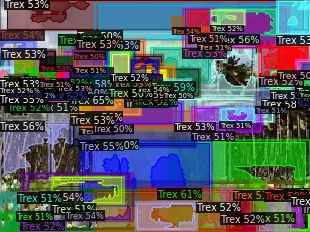

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[178.1064,  57.1512, 220.9102,  78.1704],
        [170.4513, 162.8498, 183.2114, 168.6521],
        [ 86.5374,  11.9681, 137.2791,  37.8216],
        [166.6843, 154.1021, 187.8015, 165.8165],
        [ 54.0498, 164.4964,  73.6871, 177.5186],
        [194.0165,  55.5779, 220.2812,  71.2923],
        [ 19.7100,  88.5491, 203.9720, 179.1362],
        [121.7206, 159.3050, 143.5724, 169.6790],
        [ 57.3887, 107.6212, 263.5373, 179.7174],
        [170.2199, 159.5107, 184.7871, 166.6907],
        [193.5159,  65.1972, 220.7983,  76.6791],
        [ 59.7677, 165.9589, 121.1806, 182.5422],
        [167.9112, 159.2245, 188.6886, 169.7969],
        [133.5616, 166.6

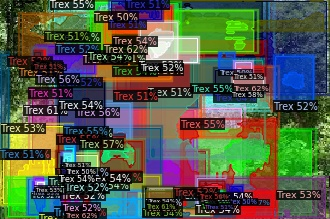

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[2.1165e+02, 1.0670e+02, 2.5729e+02, 1.3012e+02],
        [8.6977e+01, 4.3942e+01, 1.9938e+02, 9.9445e+01],
        [1.1649e+02, 1.4250e+01, 1.6687e+02, 4.0177e+01],
        [2.2783e+02, 9.3373e+01, 2.6191e+02, 1.3007e+02],
        [1.8027e+02, 1.0523e+02, 1.9454e+02, 1.2038e+02],
        [1.4904e+02, 3.5931e+01, 1.8389e+02, 4.8020e+01],
        [6.0463e+01, 4.5533e-01, 1.8285e+02, 2.6704e+01],
        [1.9616e+02, 1.7939e+02, 2.5887e+02, 1.9188e+02],
        [2.3730e+02, 6.8019e+01, 2.6195e+02, 9.5356e+01],
        [1.2402e+02, 1.0192e+01, 1.9518e+02, 3.5126e+01],
        [2.2167e+02, 1.8078e+02, 2.5529e+02, 1.9118e+02],
        [0.0000e+00, 1.3670e+02, 1.4272e+01, 1.5461e+0

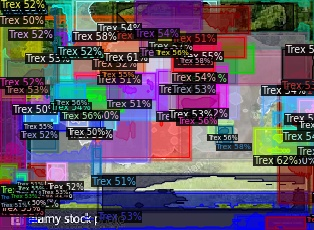

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[8.0371e+01, 2.5315e+02, 9.9525e+01, 2.6452e+02],
        [0.0000e+00, 0.0000e+00, 1.8265e+02, 2.8181e+01],
        [1.0297e+02, 2.5386e+02, 1.0917e+02, 2.6104e+02],
        [1.1253e+02, 2.0393e+02, 1.2940e+02, 2.2523e+02],
        [4.4297e+01, 1.0995e+02, 1.4486e+02, 1.6271e+02],
        [6.4178e+01, 5.5044e+01, 1.8287e+02, 1.6756e+02],
        [5.0067e+01, 1.9736e+02, 1.0089e+02, 2.1911e+02],
        [1.0330e+01, 2.5512e+02, 1.8218e+02, 2.7432e+02],
        [1.3708e+02, 2.3018e+02, 1.6208e+02, 2.4010e+02],
        [8.0335e+01, 2.4592e+02, 9.9427e+01, 2.5836e+02],
        [1.3579e+02, 2.3406e+02, 1.6027e+02, 2.4515e+02],
        [4.0111e+01, 7.6689e+01, 1.8247e+02, 2.2729e+02],
        [5.9669e+01, 1.2258e+02, 9.5229e+01, 1.5867e+02],
        [4.6752e+01, 1.9188e+02, 1.0143e+02, 2.1062e+02],
        [8.3936e+01, 2.5063e+02, 9.7749e+01, 2.58

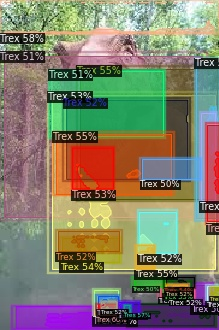

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[3.0618e+01, 1.0647e+02, 5.4261e+01, 1.1980e+02],
        [1.1401e+01, 2.3136e+01, 7.2814e+01, 6.9932e+01],
        [7.6011e+00, 1.0193e+02, 3.7166e+01, 1.1182e+02],
        [0.0000e+00, 3.9876e+01, 2.3271e+02, 1.5546e+02],
        [2.4873e+02, 9.2446e+01, 2.5898e+02, 9.7585e+01],
        [4.1589e+01, 9.4289e+01, 9.7831e+01, 9.9321e+01],
        [5.5233e+01, 1.4312e+02, 6.9019e+01, 1.4988e+02],
        [1.9968e+01, 9.6529e+01, 5.1455e+01, 1.0580e+02],
        [4.6239e+01, 9.6617e+01, 8.2057e+01, 1.0336e+02],
        [4.6515e+01, 9.8039e+01, 7.9551e+01, 1.0749e+02],
        [4.8789e+01, 9.6053e+01, 7.6311e+01, 1.0033e+02],
        [2.1984e+01, 1.3378e+02, 3.2402e+01, 1.5443e+02],
        [3.1266e+01, 1.0096e+02, 5.7397e+01, 1.1088e+02],
      

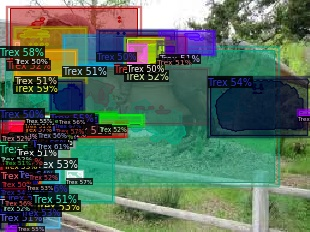

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[1.4101e+02, 1.2261e+02, 1.7860e+02, 1.4449e+02],
        [2.4596e+02, 1.7103e+02, 2.6087e+02, 1.7782e+02],
        [1.9278e+02, 1.1966e+02, 2.4609e+02, 1.4217e+02],
        [1.8456e+02, 1.6719e+02, 2.3051e+02, 1.8292e+02],
        [1.1613e+02, 1.6901e+02, 1.8156e+02, 1.8292e+02],
        [1.9667e+02, 1.6606e+02, 2.4965e+02, 1.8292e+02],
        [2.2662e+02, 1.7053e+02, 2.7260e+02, 1.8299e+02],
        [1.5887e+02, 1.4154e+02, 2.5689e+02, 1.8193e+02],
        [2.4478e+02, 1.7091e+02, 2.6463e+02, 1.8264e+02],
        [1.3163e+02, 1.7132e+02, 1.6021e+02, 1.8251e+02],
        [8.1108e+01, 1.4912e+02, 1.3042e+02, 1.7187e+02]

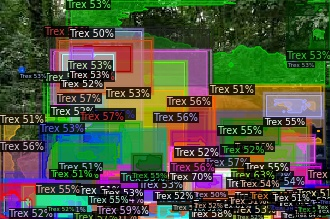

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[2.1861e+02, 1.1966e+02, 2.3193e+02, 1.2493e+02],
        [2.1943e+02, 1.1608e+02, 2.3264e+02, 1.2101e+02],
        [2.4302e+02, 5.8133e+00, 2.9152e+02, 2.7666e+01],
        [2.5304e+02, 1.3330e+02, 2.8403e+02, 1.4293e+02],
        [1.5659e+02, 1.5182e+02, 2.9930e+02, 1.6793e+02],
        [2.6468e+02, 1.2336e+02, 2.9471e+02, 1.3050e+02],
        [2.2874e+01, 7.3927e+01, 2.4786e+02, 1.5723e+02],
        [2.1719e+02, 1.1419e+02, 2.3348e+02, 1.2314e+02],
        [2.6643e+02, 1.2269e+02, 2.7338e+02, 1.2739e+02],
        [2.4419e+02, 1.2938e+02, 2.9185e+02, 1.4337e+02],
        [5.7230e+01, 6.0192e+01, 6.4163e+01, 6.8180e+01],
        [0.0000e+00, 6.9657e+01, 2.8542e+01, 1.0780e+02],
        [2.7112e+02, 1.2484e+02, 2.9571e+02, 1.3506e+02],
        [2.1

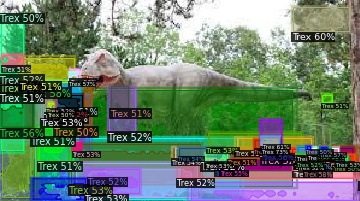

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Boxes(tensor([[1.0522e+02, 1.5181e+02, 1.5988e+02, 1.5733e+02],
        [1.0327e+02, 1.5047e+02, 1.7261e+02, 1.6257e+02],
        [9.9930e+01, 1.5450e+02, 1.8378e+02, 1.6663e+02],
        [2.6577e+02, 5.2257e+01, 2.7785e+02, 5.6414e+01],
        [1.6163e+02, 1.0197e+02, 2.8899e+02, 1.6851e+02],
        [1.0292e+02, 1.4369e+02, 1.6337e+02, 1.7394e+02],
        [2.5987e+01, 5.7011e+01, 1.9791e+02, 1.6016e+02],
        [5.2695e+01, 3.9479e+01, 1.6918e+02, 9.7415e+01],
        [1.9334e+02, 7.8353e+01, 2.8929e+02, 1.3222e+02],
        [3.8635e+01, 6.6035e+01, 6.6097e+01, 7.5754e+01],
        [1.1484e+02, 4.1172e+01, 1.5277e+02, 5.1183e+01],
        [9.6634e+01, 1.0427e+02, 1.9699e+02, 1.5268e+02],
        [9.7626e+01, 9.8817e+01, 1.3464e+02, 1.2223e+02],
        [

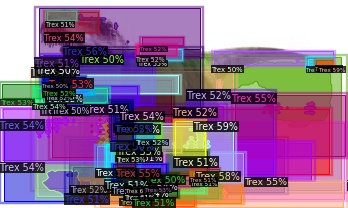

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
Boxes(tensor([[0.0000e+00, 1.5518e+02, 1.1892e+01, 1.5900e+02],
        [8.5496e+01, 1.2141e+02, 1.1460e+02, 1.3062e+02],
        [5.4863e+01, 1.4763e+02, 1.3355e+02, 1.5757e+02],
        [1.4317e+02, 1.1510e+02, 2.5212e+02, 1.5212e+02],
        [7.4643e+01, 1.2469e+02, 1.2008e+02, 1.2964e+02],
        [0.0000e+00, 1.0121e+02, 8.7344e+01, 1.5523e+02],
        [5.6288e+01, 1.2674e+02, 1.3645e+02, 1.3999e+02],
        [8.6343e+01, 9.8036e+01, 1.1045e+02, 1.0758e+02],
        [2.2917e+02, 3.4748e+01, 2.7425e+02, 6.2066e+01],
        [6.1621e+01, 1.2022e+02, 1.2761e+02, 1.3576e+02],
        [2.8471e+02, 6.4619e+01, 3.1440e+02, 8.0011e+01],
        [5.9017e+

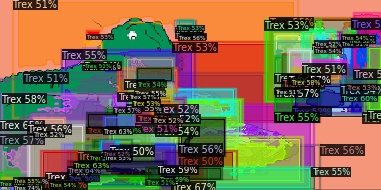

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
Boxes(tensor([[ 68.7659, 218.0288, 572.7396, 429.7364],
        [415.7137, 323.2794, 531.8593, 373.7660],
        [349.9510,  84.3606, 408.4651, 115.1252],
        [  0.0000, 317.0240, 139.0530, 367.3533],
        [268.3072, 377.2429, 302.1866, 408.9461],
        [  9.4004, 155.9043, 146.5795, 223.8428],
        [303.8101, 306.5218, 374.8622, 336.8499],
        [200.9979, 139.8926, 254.1446, 170.5557],
        [300.2247, 337.6885, 405.9619, 403.5580],
        [171.9472, 341.9754, 447.1907, 414.9848],
        [410.7191, 294.4576, 478.1707, 321.2472],
        [317.6748, 327.2816, 332.0446, 343.5926],
        [310.9677, 296.0736, 396.6480, 369.1684],
     

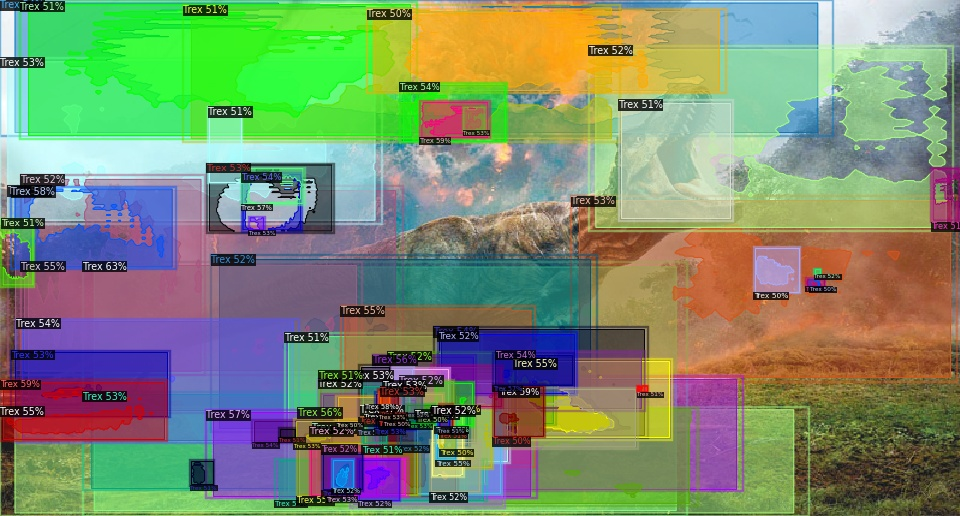

In [7]:
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
for x in os.listdir(os.path.join(base_path,"test")):
    im = cv2.imread(os.path.join(base_path,"test",x))    
    outputs = predictor(im)
    print(outputs["instances"].pred_classes)
    print(outputs["instances"].pred_boxes)
    v = Visualizer(
        im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow( out.get_image()[:, :, ::-1])
    